# Week 8 Tutorial - Question 1 Solution

Using the data set 'tripadvisor_review.csv', cluster the data using k-means and a GMM and detect abnormal travelers. You can detect abnormalities by analysing how well a point fits the model. In the case of K-means, this means how far it is from the cluster centre relative to other points in the cluster, and for a GMM this means the negative log likelihood of the sample. You should split the data into a training and testing set (use the first $700$ samples for training) and detect travellers with abnormal opinions in the remaining $280$ samples. In completing this question you should consider the following:
1.  Determine the best value of $k$ for both K-means and the GMM.
2.  Visualise the learned clusters or cluster centres, and explore how the cluster distribution changes as you change the random seed.
3. Are the abnormal travellers detected the same for both methods? Are these travellers consistent across different random seeds?

Using the data set 'tripadvisor_review.csv', cluster the data using k-means and a GMM and detect abnormal
This data is composed of reviews on destinations in 10 categories mentioned across East Asia. Each traveler rating is mapped as Excellent(4), Very Good(3), Average(2), Poor(1), and Terrible(0) and average rating is used.

In [1]:
import pandas
import numpy
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from matplotlib import cm
from datetime import datetime

## Read the data and setup

This data is traveller ratings for 10 categories of activity, so we can (hopefully) see different types of travellers. The 10 activities are:
* Average user feedback on art galleries 
* Average user feedback on dance clubs 
* Average user feedback on juice bars 
* Average user feedback on restaurants 
* Average user feedback on museums 
* Average user feedback on resorts 
* Average user feedback on parks/picnic spots 
* Average user feedback on beaches 
* Average user feedback on theaters 
* Average user feedback on religious institutions

From the data, we can see that we have 980 users. The first column is a useless user ID, the rest are our category ratings.

In [2]:
data = pandas.read_csv('../data/tripadvisor_review.csv');
print(data)

      User ID  Category 1  Category 2  Category 3  Category 4  Category 5  \
0      User 1        0.93        1.80        2.29        0.62        0.80   
1      User 2        1.02        2.20        2.66        0.64        1.42   
2      User 3        1.22        0.80        0.54        0.53        0.24   
3      User 4        0.45        1.80        0.29        0.57        0.46   
4      User 5        0.51        1.20        1.18        0.57        1.54   
..        ...         ...         ...         ...         ...         ...   
975  User 976        0.74        1.12        0.30        0.53        0.88   
976  User 977        1.25        0.92        1.12        0.38        0.78   
977  User 978        0.61        1.32        0.67        0.43        1.30   
978  User 979        0.93        0.20        0.13        0.43        0.30   
979  User 980        0.93        0.56        1.13        0.51        1.34   

     Category 6  Category 7  Category 8  Category 9  Category 10  
0       

We'll keep our data split very simple. The first 700 travellers form the training set, the rest go into testing. As noted above, we'll drop the first column as it contains nothing useful.

In [3]:
train = data.iloc[0:700, 1:]
test = data.iloc[700:, 1:]

## Part 1: Find the best K

Firt up, we'll find the best K. We'll do this for K-means and the GMM. In both cases, to be a bit more thorough, we'll run each method 10 times will different random seeds and average the results.

### K-Means

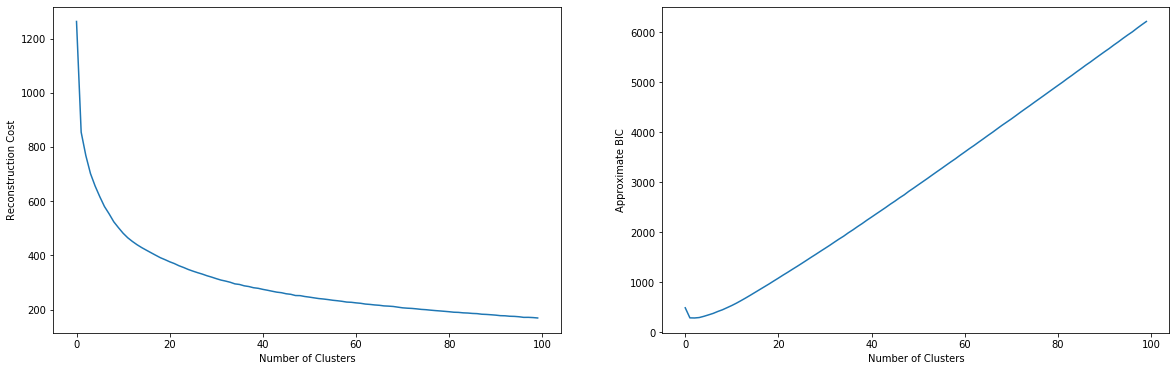

In [4]:
num_itts = 10

costs = [];
approx_bic = []
for i in range(100):
    c = 0
    a_b = 0
    for r in range(num_itts):
        kmeans = KMeans(n_clusters=i+1, random_state=r).fit(train)

        k = numpy.shape(kmeans.cluster_centers_)[0]*(numpy.shape(kmeans.cluster_centers_)[1] + 1)
        m = len(train)
        
        c += kmeans.inertia_
        a_b += m*numpy.log(kmeans.inertia_ / m) + k*numpy.log(m)

    costs.append(c / num_itts)
    approx_bic.append(a_b / num_itts)

fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(costs)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Reconstruction Cost');  

ax = fig.add_subplot(1, 2, 2)
ax.plot(approx_bic)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Approximate BIC');  

From the above plots we see that a small K is best. The approx BIC curve bottoms-out very quickly, and the reconstruction cost curve also flattens out quickly.

For now, we'll proceed with the best K of 3 (according to approximate BIC).

In [5]:
numpy.argmin(approx_bic) + 1

3

### GMM

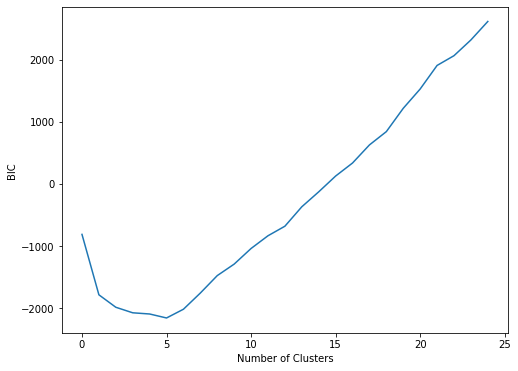

In [6]:
bics = []
for i in range (25):
    b = 0
    for r in range(num_itts):
        gmm = GaussianMixture(i+1, random_state=r)
        gmm.fit(train)
        b += gmm.bic(train)
    bics.append(b / num_itts)
    
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(bics)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('BIC');

This time our minimum is a bit bigger at 6.

In [7]:
numpy.argmin(bics) + 1

6

## Part 2 and 3: Visualisation and finding Weird Travellers

So we can explore effects as we change the random seed, we'll wrap this up in a function. Our function will:
* Train a model, given a number of clusters and random seed
* Visualise the cluster centres and clustering results
* Visualise the most unusual people we can find

We'll write one function for K-means and one for a GMM.

### K-Means

In [8]:
def do_kmeans_analysis(n_clusters, random_state, train, test, abnormal_threshold = 2):

    # train the k-means model
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(train)
    
    # plot the cluster centres
    x = ['art', 'dance', 'juice', 'food', 'museums', 'resort', 'parks', 'beach', 'theatre', 'religion']
    fig = plt.figure(figsize=[20, 10])
    for i in range(n_clusters):
        ax = fig.add_subplot(n_clusters, 1, i + 1)
        ax.bar(x, kmeans.cluster_centers_[i,:])
        ax.set_title('Cluster %d' % (i+1))
        
    # plot the data, we can't plot 10-d data, so we'll run TSNE and show that
    fig = plt.figure(figsize=[20,20])
    ax = fig.add_subplot(1, 1, 1)
    tsne_embeddings = TSNE(random_state=4).fit_transform(numpy.vstack([train, kmeans.cluster_centers_]))
    ax.scatter(tsne_embeddings[:-n_clusters,0], tsne_embeddings[:-n_clusters,1], c = kmeans.labels_);
    # add cluster centres to the plot
    ax.scatter(tsne_embeddings[-n_clusters:,0], tsne_embeddings[-n_clusters:,1], s=200, marker='x')
    
    # find abnormal travellers. With k-means, we'll use distance to the cluster centre as our measure
    distances = kmeans.transform(test)
    distances = numpy.min(distances, axis=1)
    
    # we need to apply a threshold to find the abnormal travellers
    num_weirdos = sum(distances > abnormal_threshold)

    # add the abnormal travelleres to the scatter plot
    for count, dist in enumerate(distances):
        if dist > abnormal_threshold:
            ax.scatter(tsne_embeddings[count,0], tsne_embeddings[count,1], s=200, marker='X')

    # plot the ratings for the abnormal travellers
    fig = plt.figure(figsize=[25, 20])
    weirdo_count = 1
    for count, dist in enumerate(distances):
        if dist > abnormal_threshold:
            ax = fig.add_subplot(num_weirdos, 1, weirdo_count)
            ax.bar(x, test.iloc[count, :])
            ax.set_title('Traveller %d; Weirdness: %f' % (count, dist))
            weirdo_count += 1    

We'll run three versions of K-means, with different random seeds.

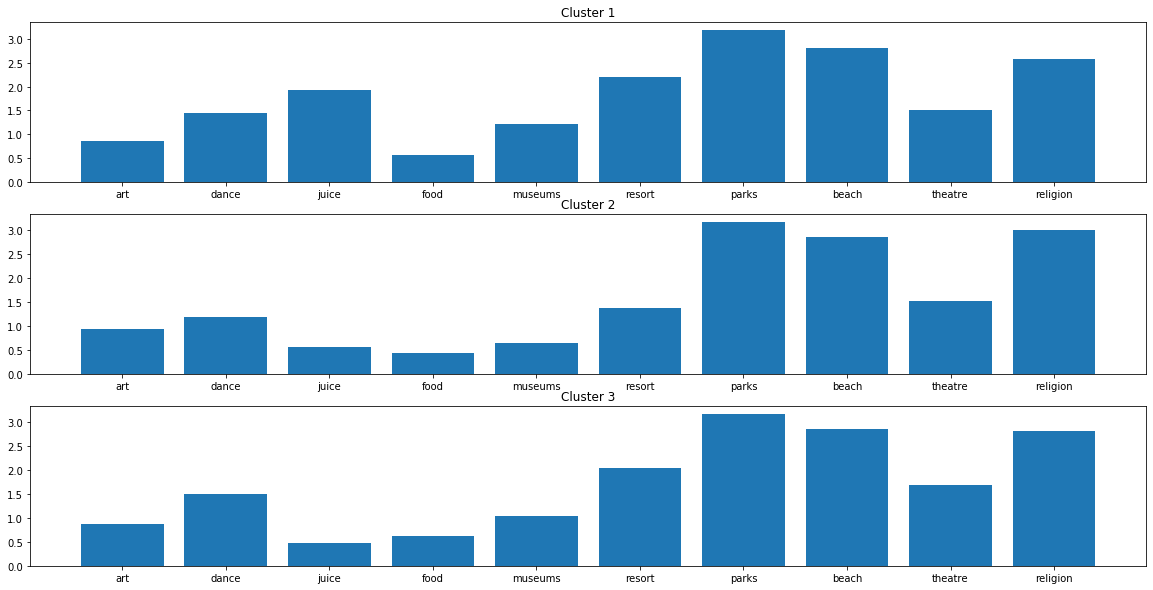

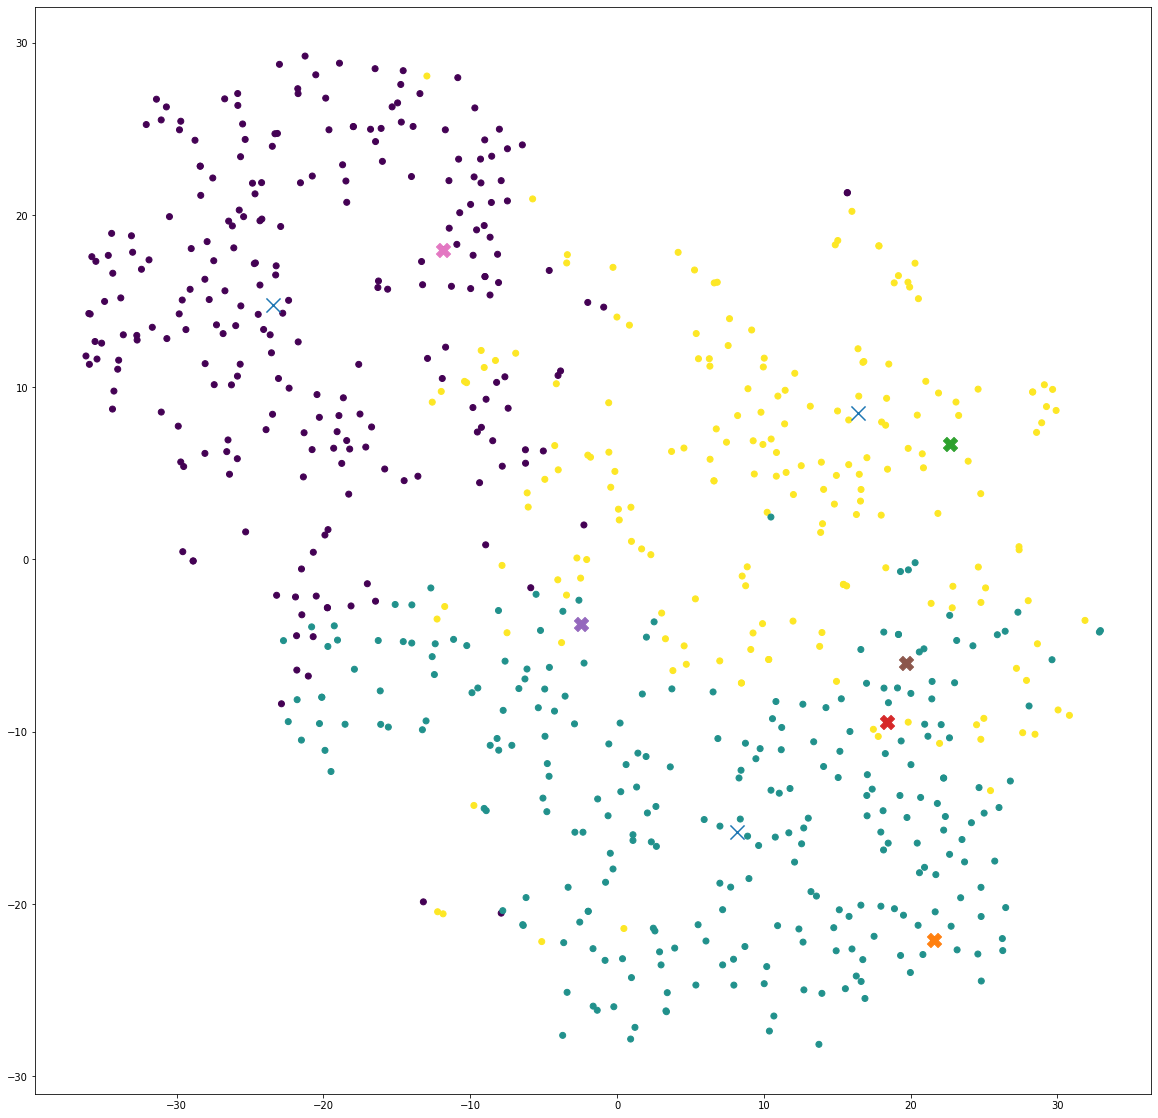

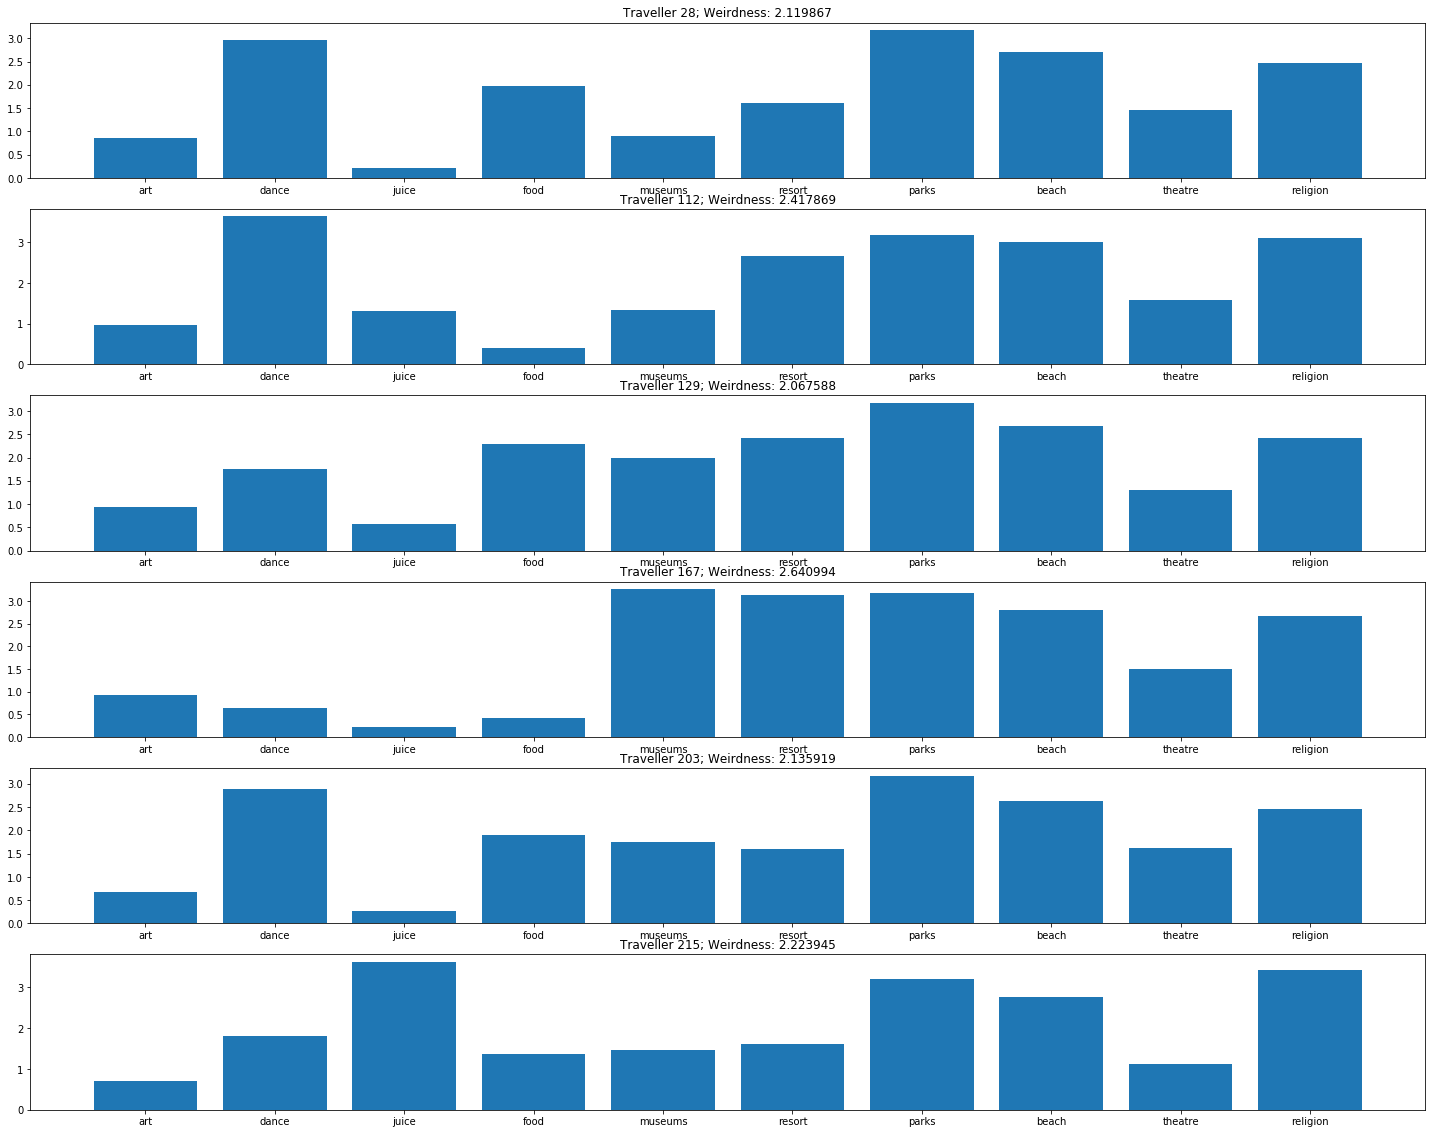

In [9]:
do_kmeans_analysis(3, 4, train, test)

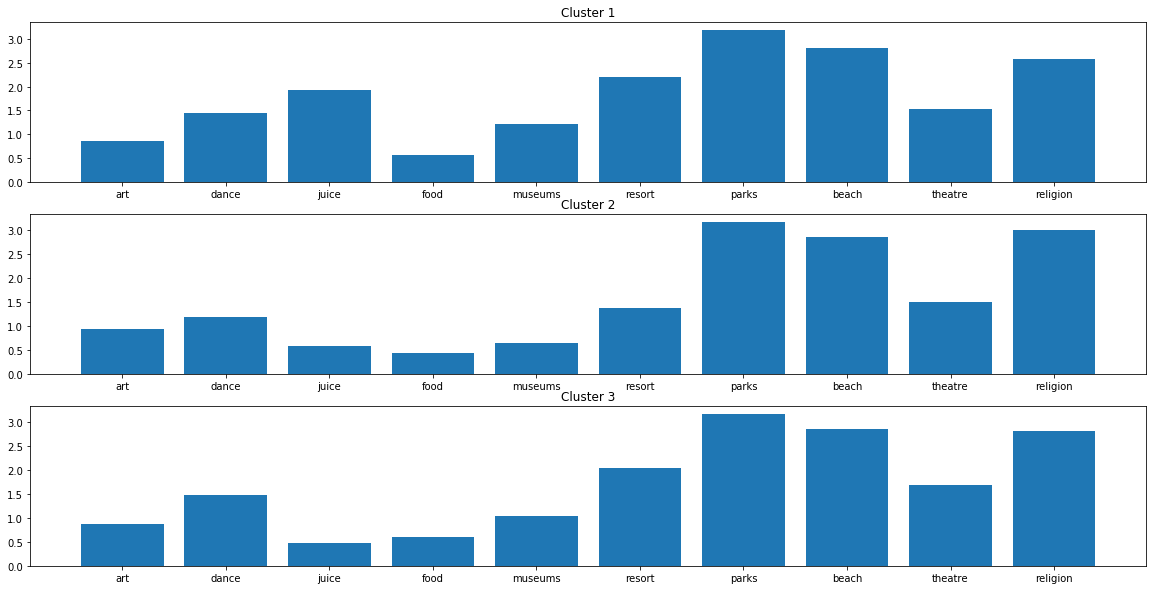

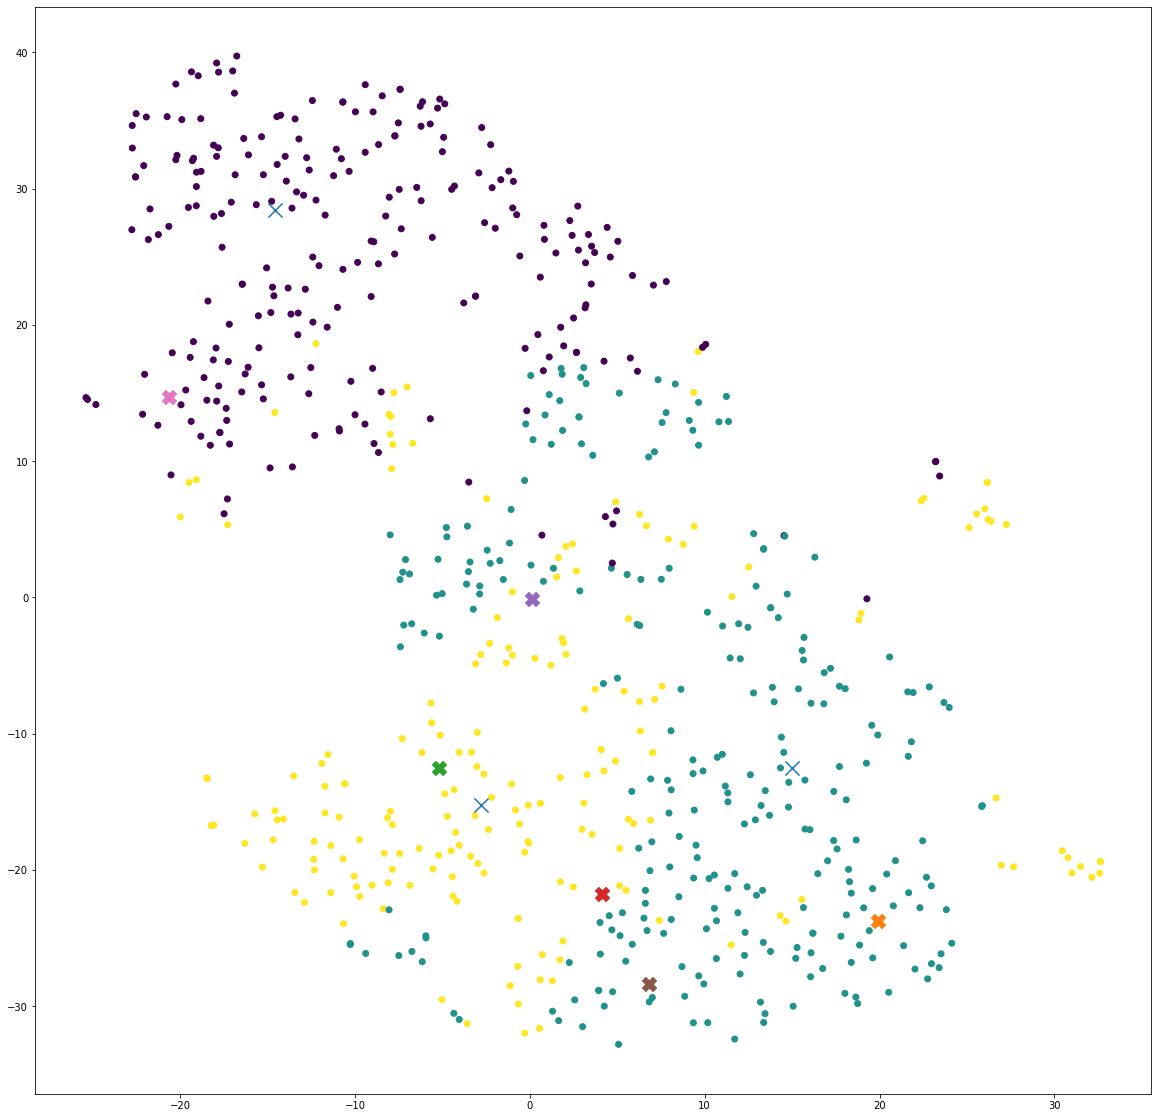

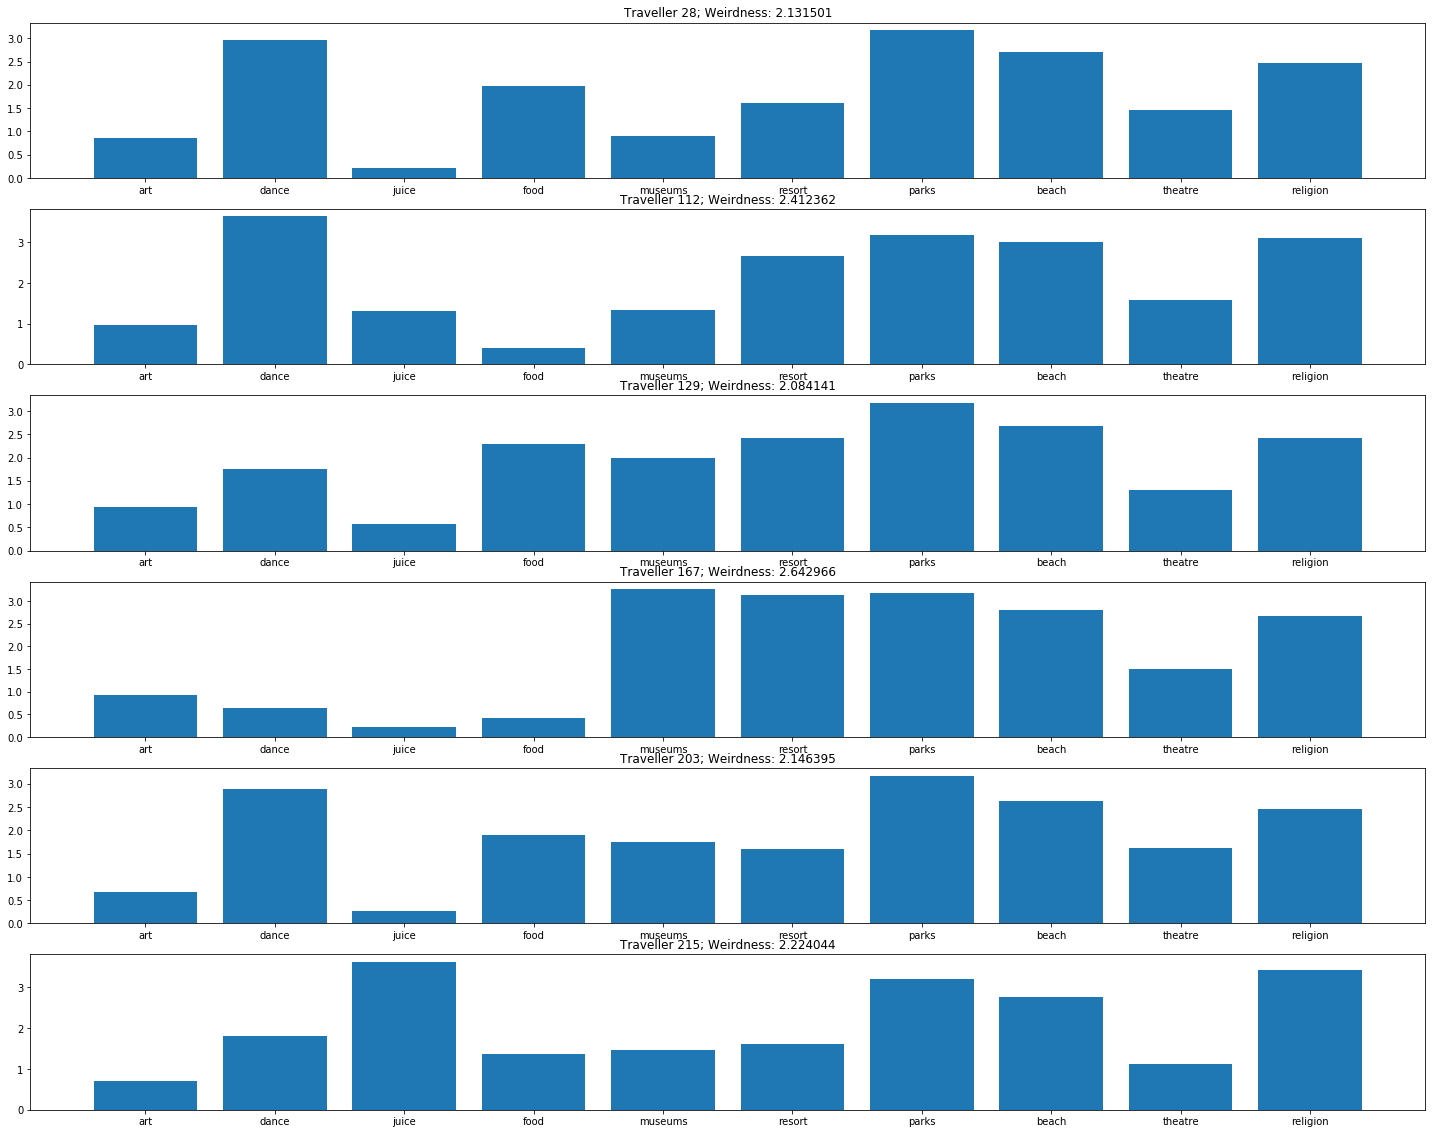

In [10]:
do_kmeans_analysis(3, 42, train, test)

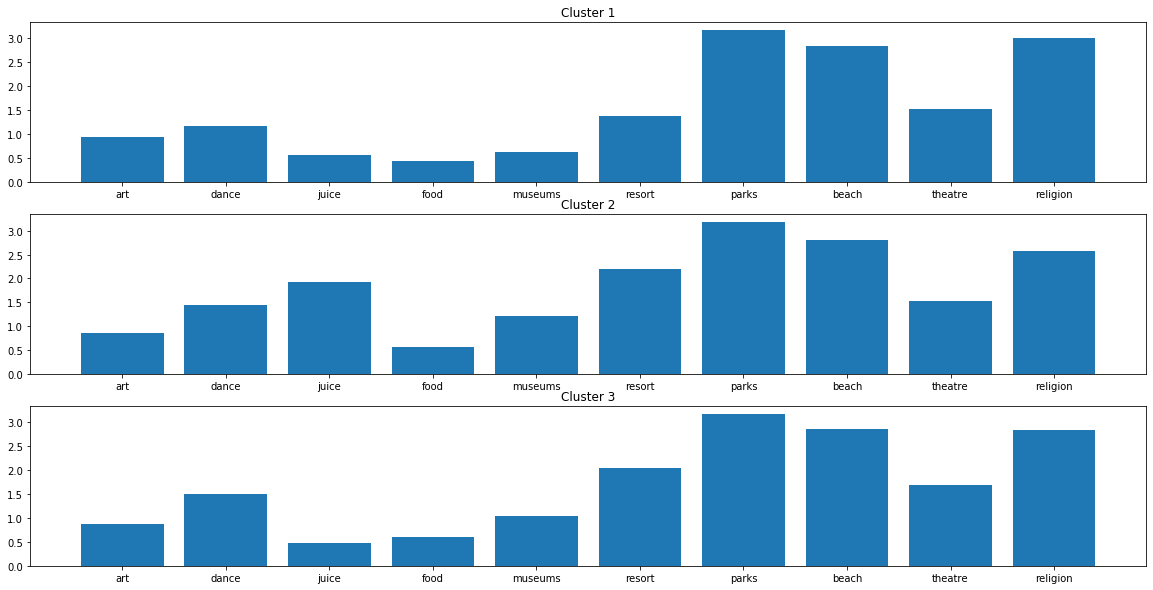

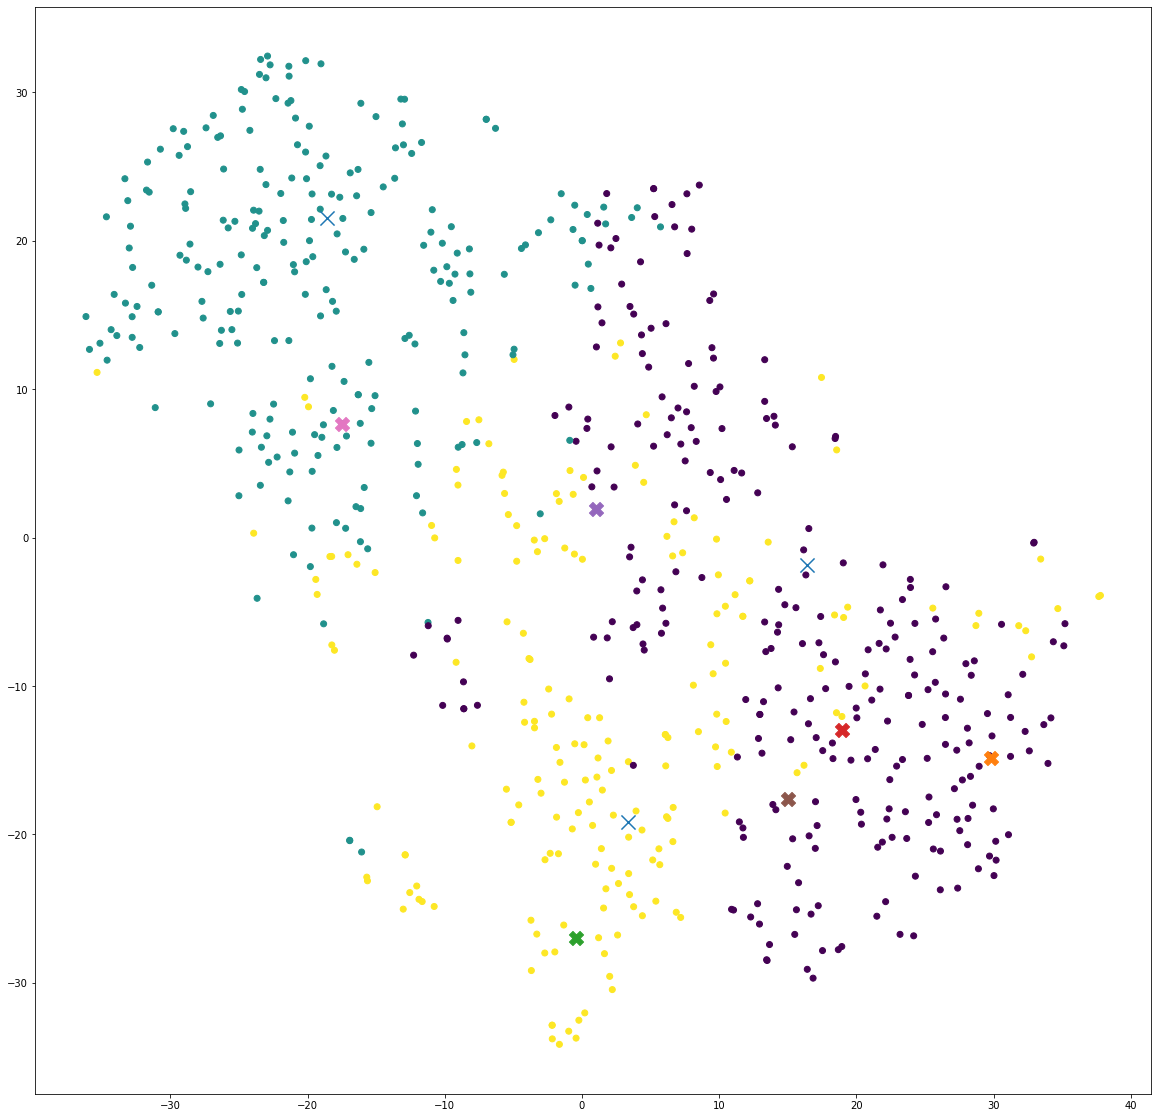

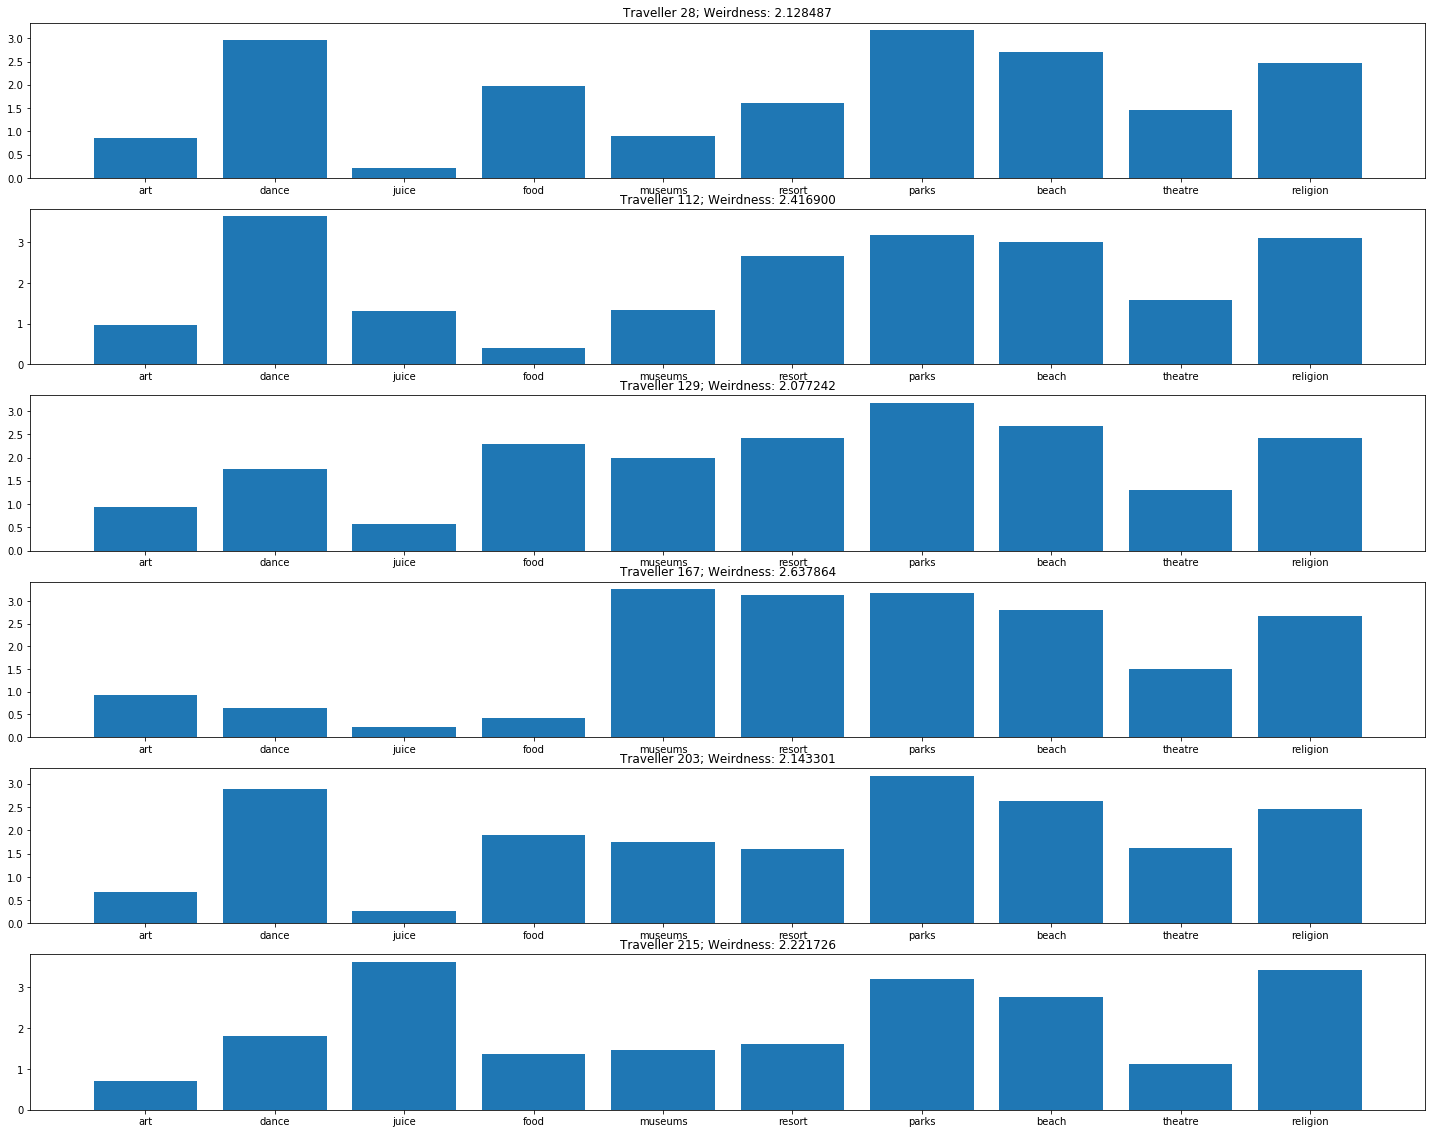

In [11]:
do_kmeans_analysis(3, 314, train, test)

What we see is:
* Clustering results don't vary greatly. Centres to change, and we don't get the same results twice, but similar patterns occur
* Abnormal travellers are exactly the same each time. Traveller indexes are 28, 112, 129, 167, 203 and 215. In each of our three test we get this set.
* From the TSNE plots, our abnormal travellers don't seem to be outliers as much as people at the boundary of clusters

Note that our TSNE plot is not a perfect visualisation of what's happening because of how TSNE works, but it's not a bad snapshop all the same.

### GMM

We'll do the same thing now for the GMM

In [12]:
def do_gmm_analysis(n_components, random_state, train, test, abnormal_threshold = -10):

    # train the GMM
    gmm = GaussianMixture(n_components=n_components, random_state=random_state).fit(train)
    
    # plot the component means
    x = ['art', 'dance', 'juice', 'food', 'museums', 'resort', 'parks', 'beach', 'theatre', 'religion']
    fig = plt.figure(figsize=[20, 10])
    for i in range(n_components):
        ax = fig.add_subplot(n_components, 1, i + 1)
        ax.bar(x, gmm.means_[i,:])
        ax.set_title('Cluster %d' % (i+1))
        
    # TSNE plot of the data
    fig = plt.figure(figsize=[20,20])
    ax = fig.add_subplot(1, 1, 1)
    tsne_embeddings = TSNE(random_state=4).fit_transform(numpy.vstack([train, gmm.means_]))
    train_labels = gmm.predict(train)
    ax.scatter(tsne_embeddings[:-n_components,0], tsne_embeddings[:-n_components,1], c = train_labels);

    # add component means to the scatter plot
    ax.scatter(tsne_embeddings[-n_components:,0], tsne_embeddings[-n_components:,1], s=200, marker='x')
    
    # compute likelihood for travellers. With a GMM, we can get the likelihood that such a traveller exists
    # given the learned distribution
    distances = gmm.score_samples(test)

    # find the weird travellers now, once again we need a threshold
    num_weirdos = sum(distances < abnormal_threshold)

    # add abnormal people to the scatter plot
    for count, dist in enumerate(distances):
        if dist < abnormal_threshold:
            ax.scatter(tsne_embeddings[count,0], tsne_embeddings[count,1], s=200, marker='X')

    # plot the opinions of the weird travellers
    fig = plt.figure(figsize=[20, 40])
    weirdo_count = 1
    for count, dist in enumerate(distances):
        if dist < abnormal_threshold:
            ax = fig.add_subplot(num_weirdos, 1, weirdo_count)
            ax.bar(x, test.iloc[count, :])
            ax.set_title('Traveller %d; Weirdness: %f' % (count, dist))
            weirdo_count += 1    

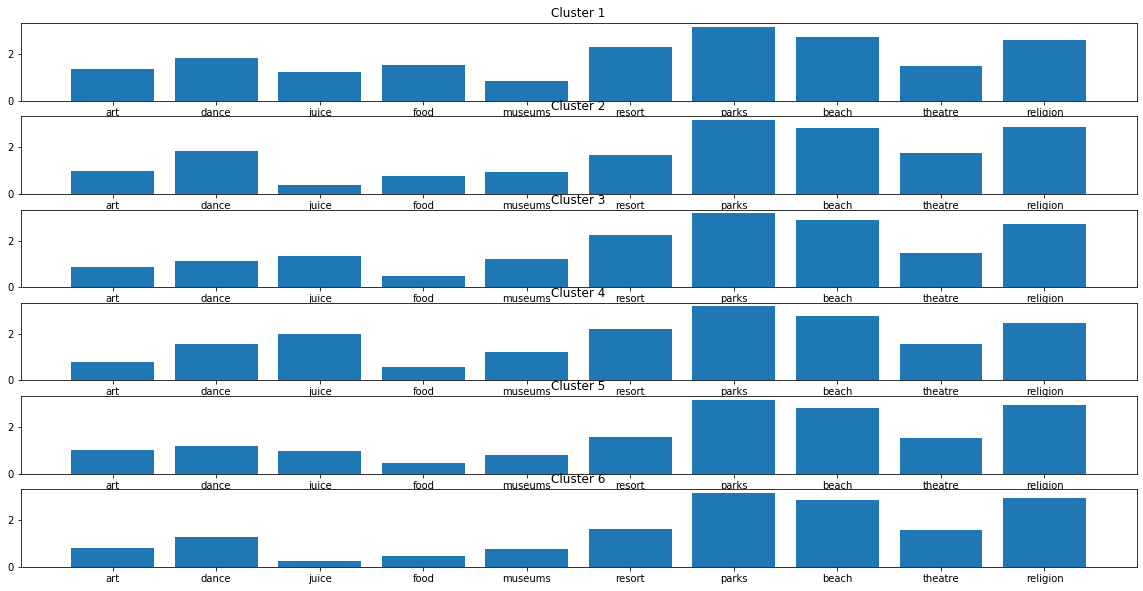

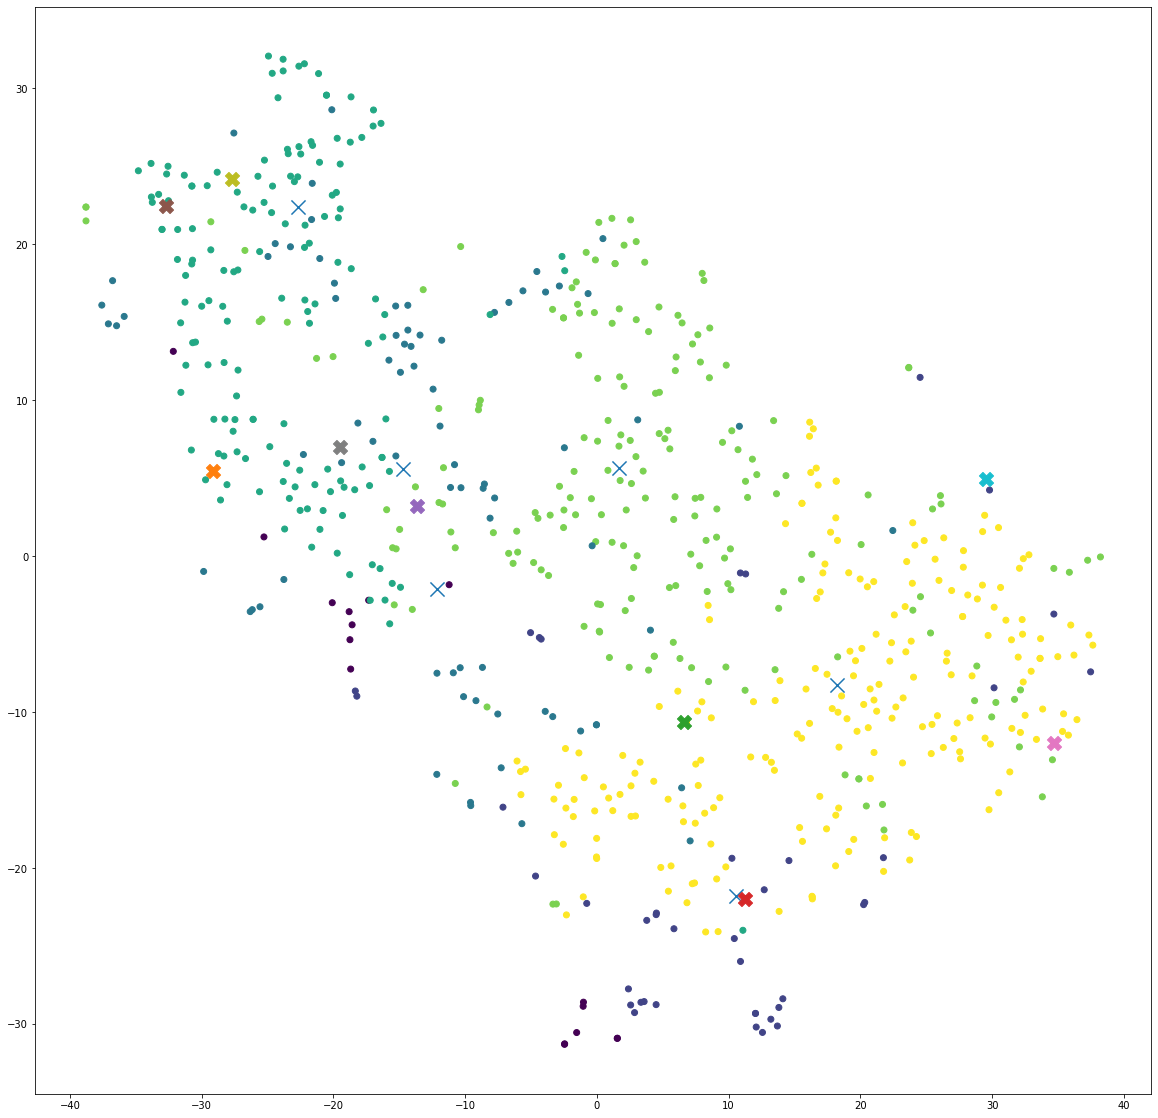

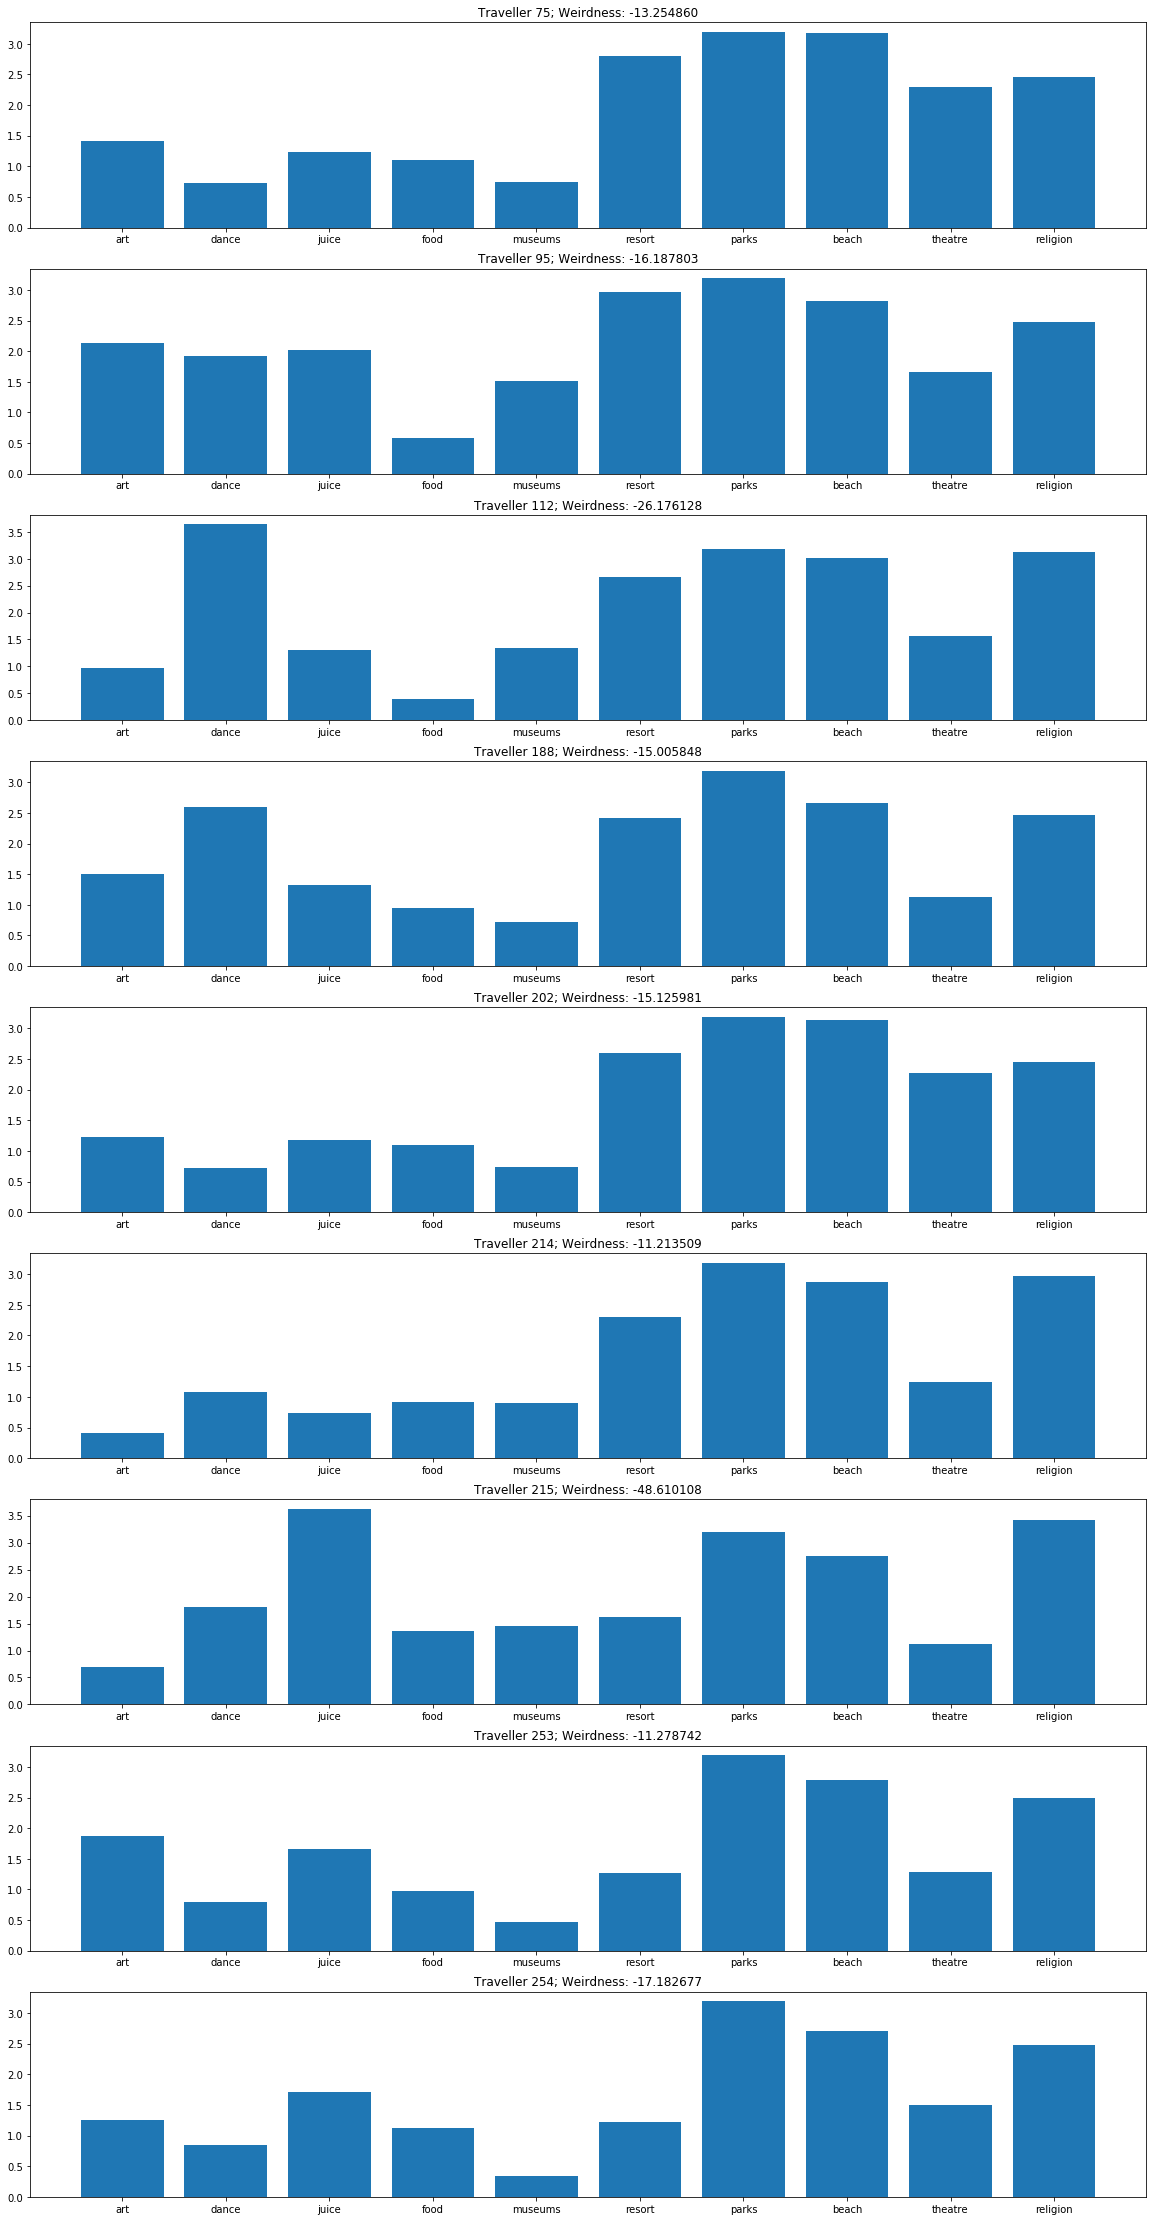

In [13]:
do_gmm_analysis(6, 4, train, test)

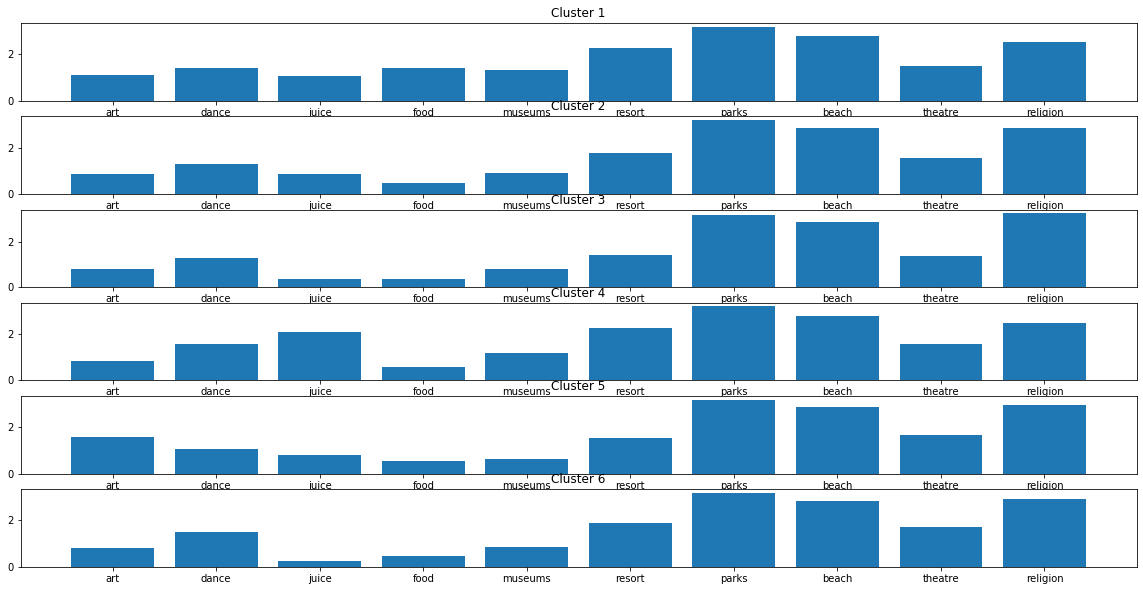

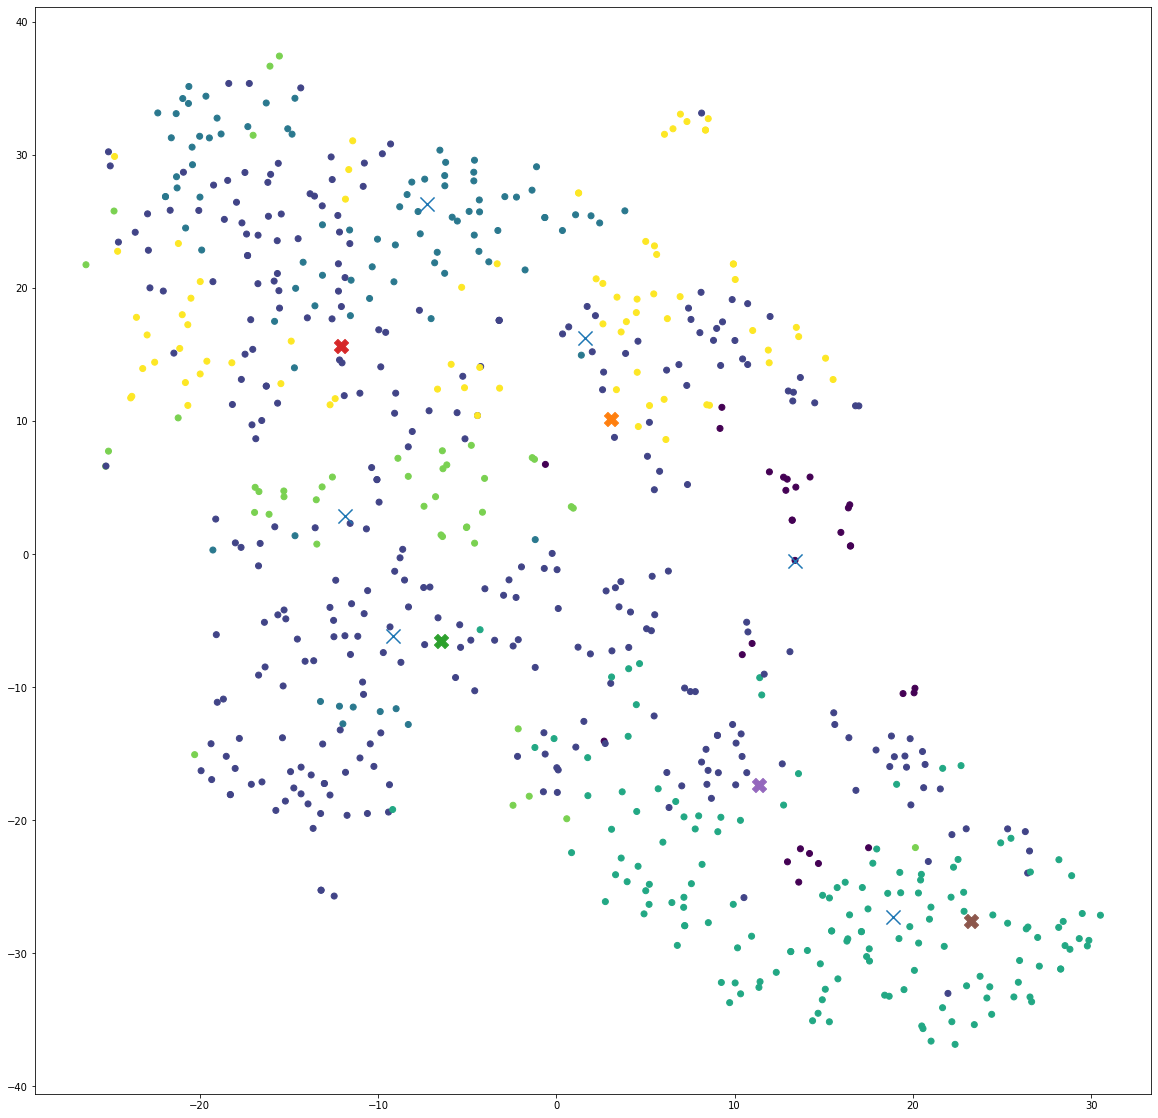

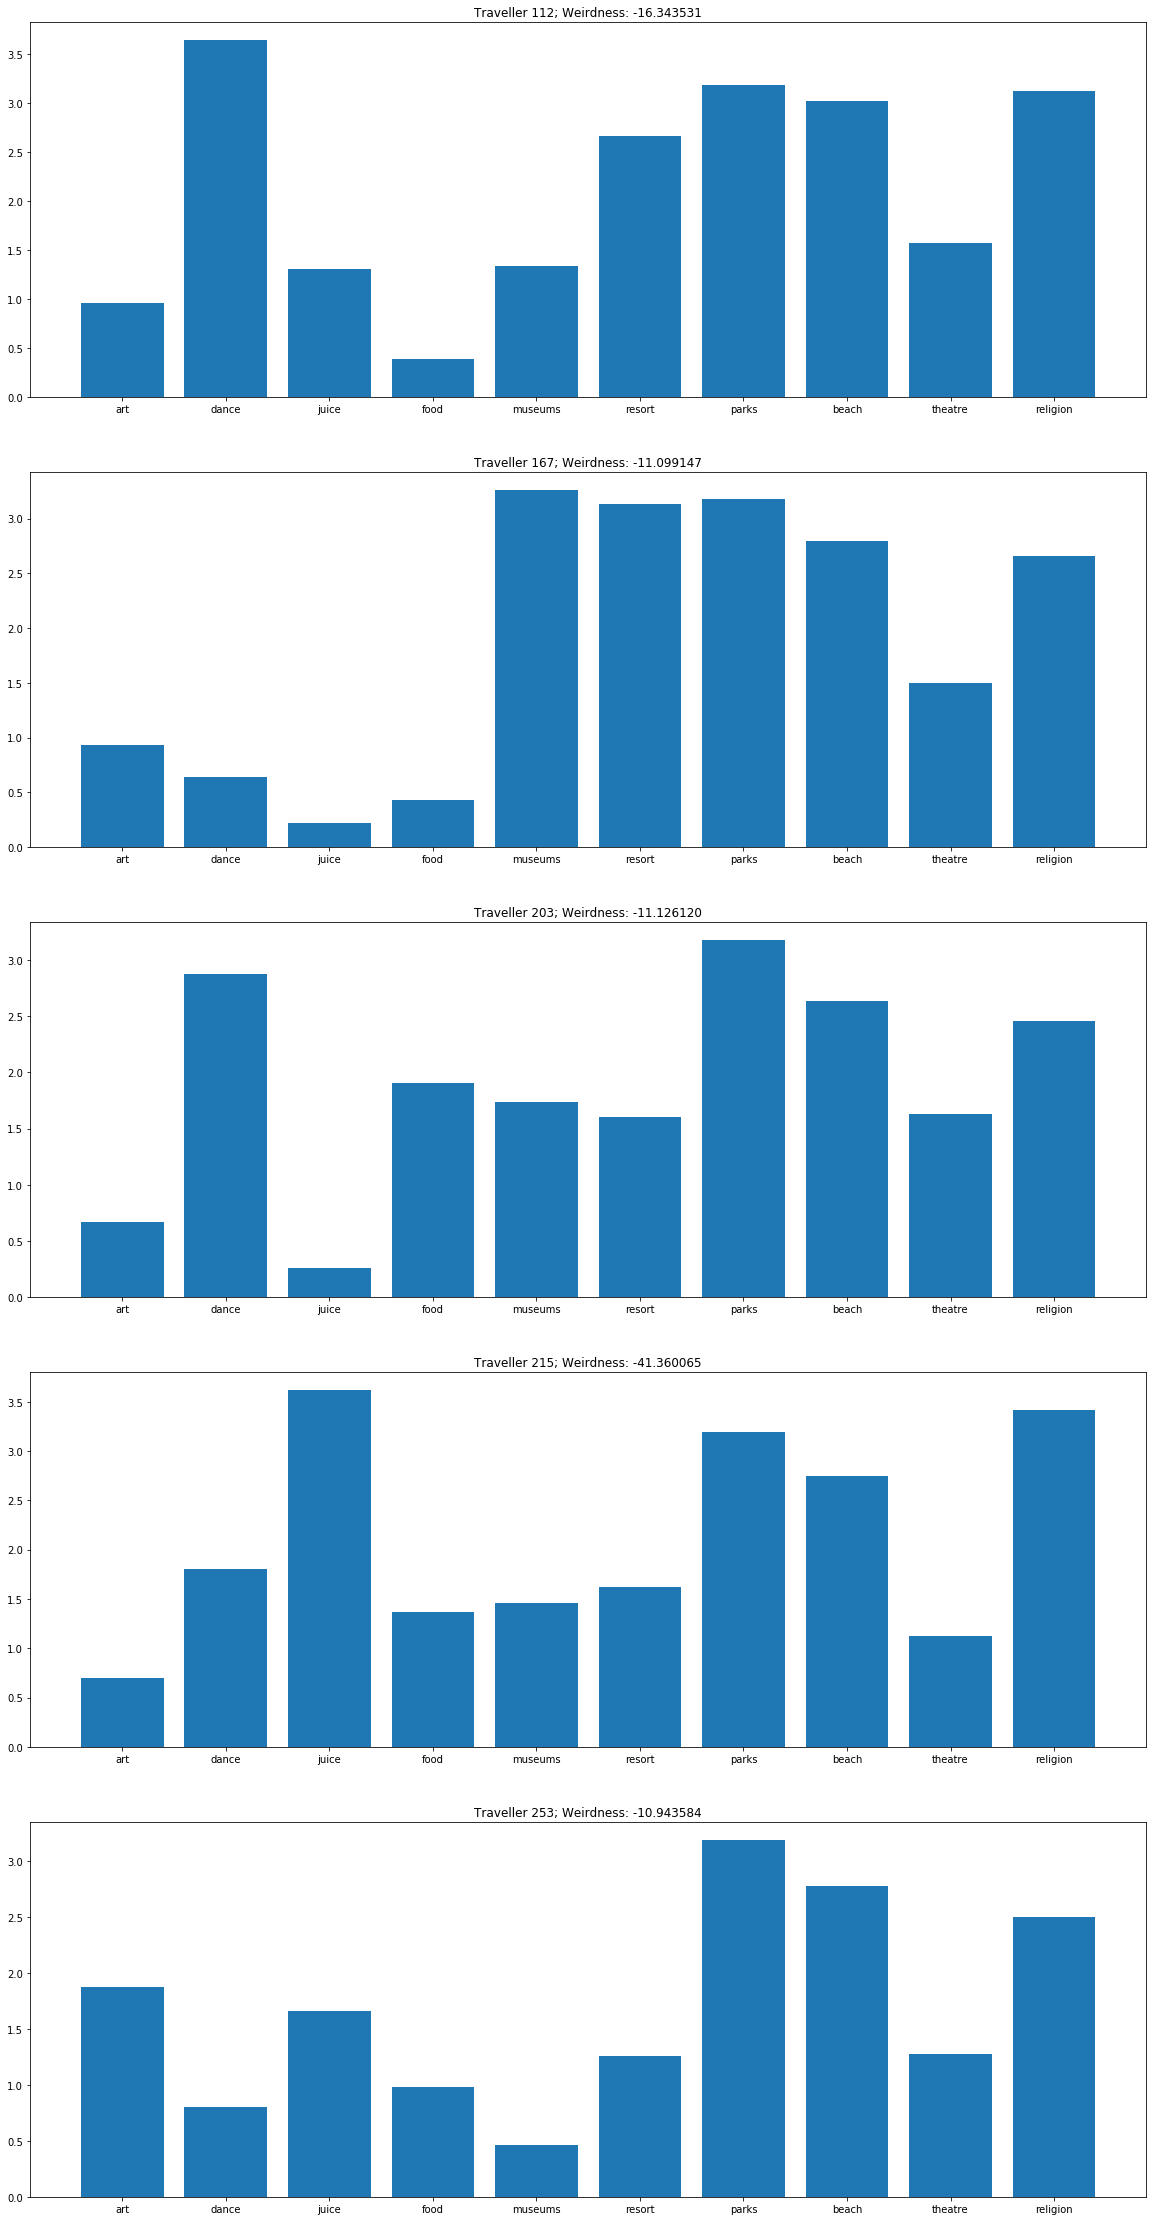

In [14]:
do_gmm_analysis(6, 42, train, test)

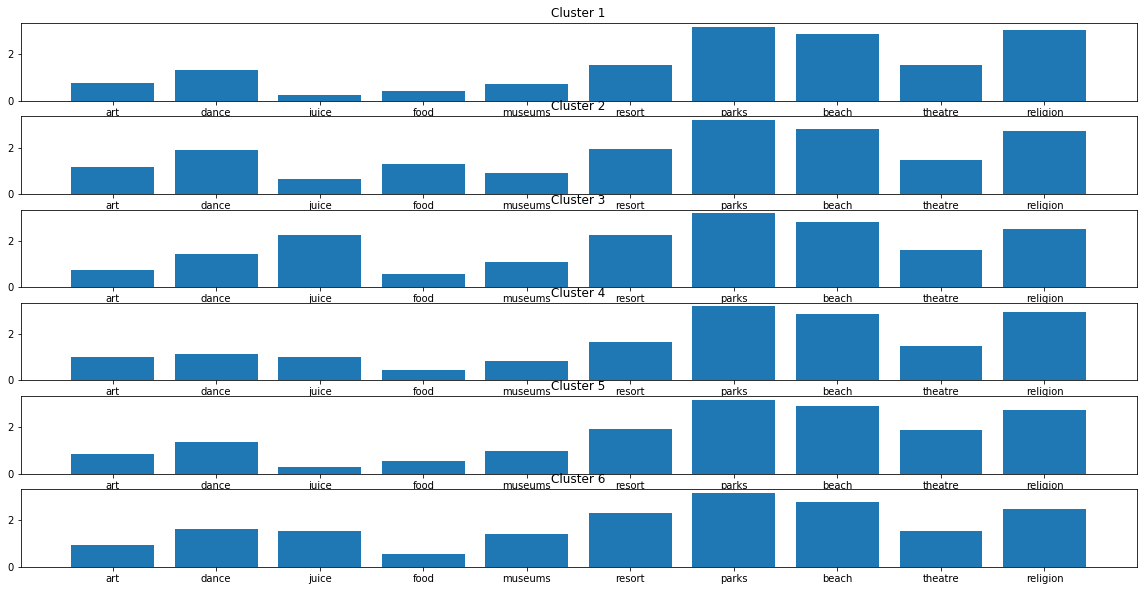

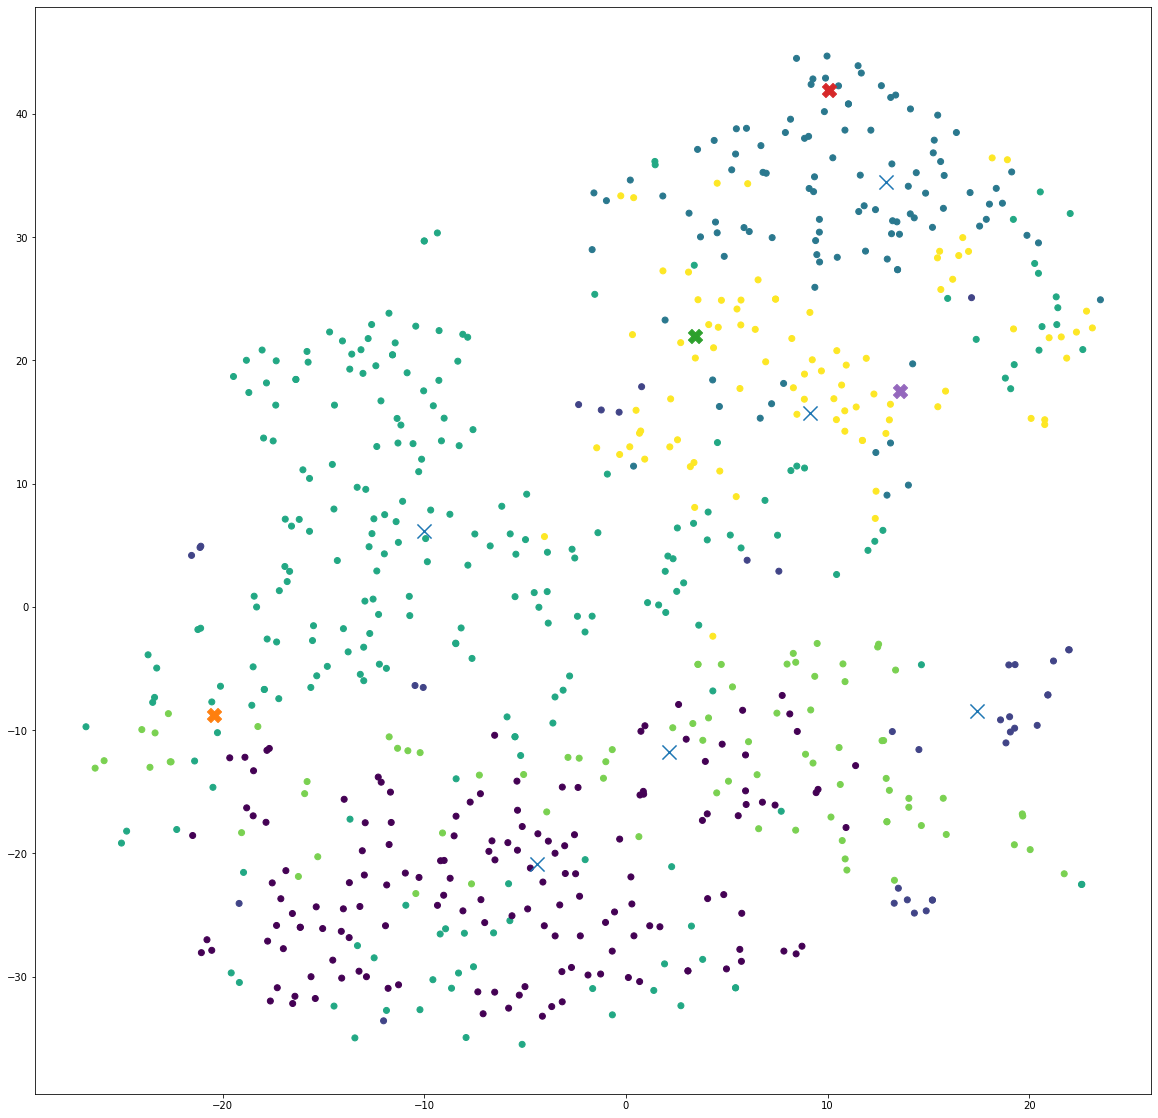

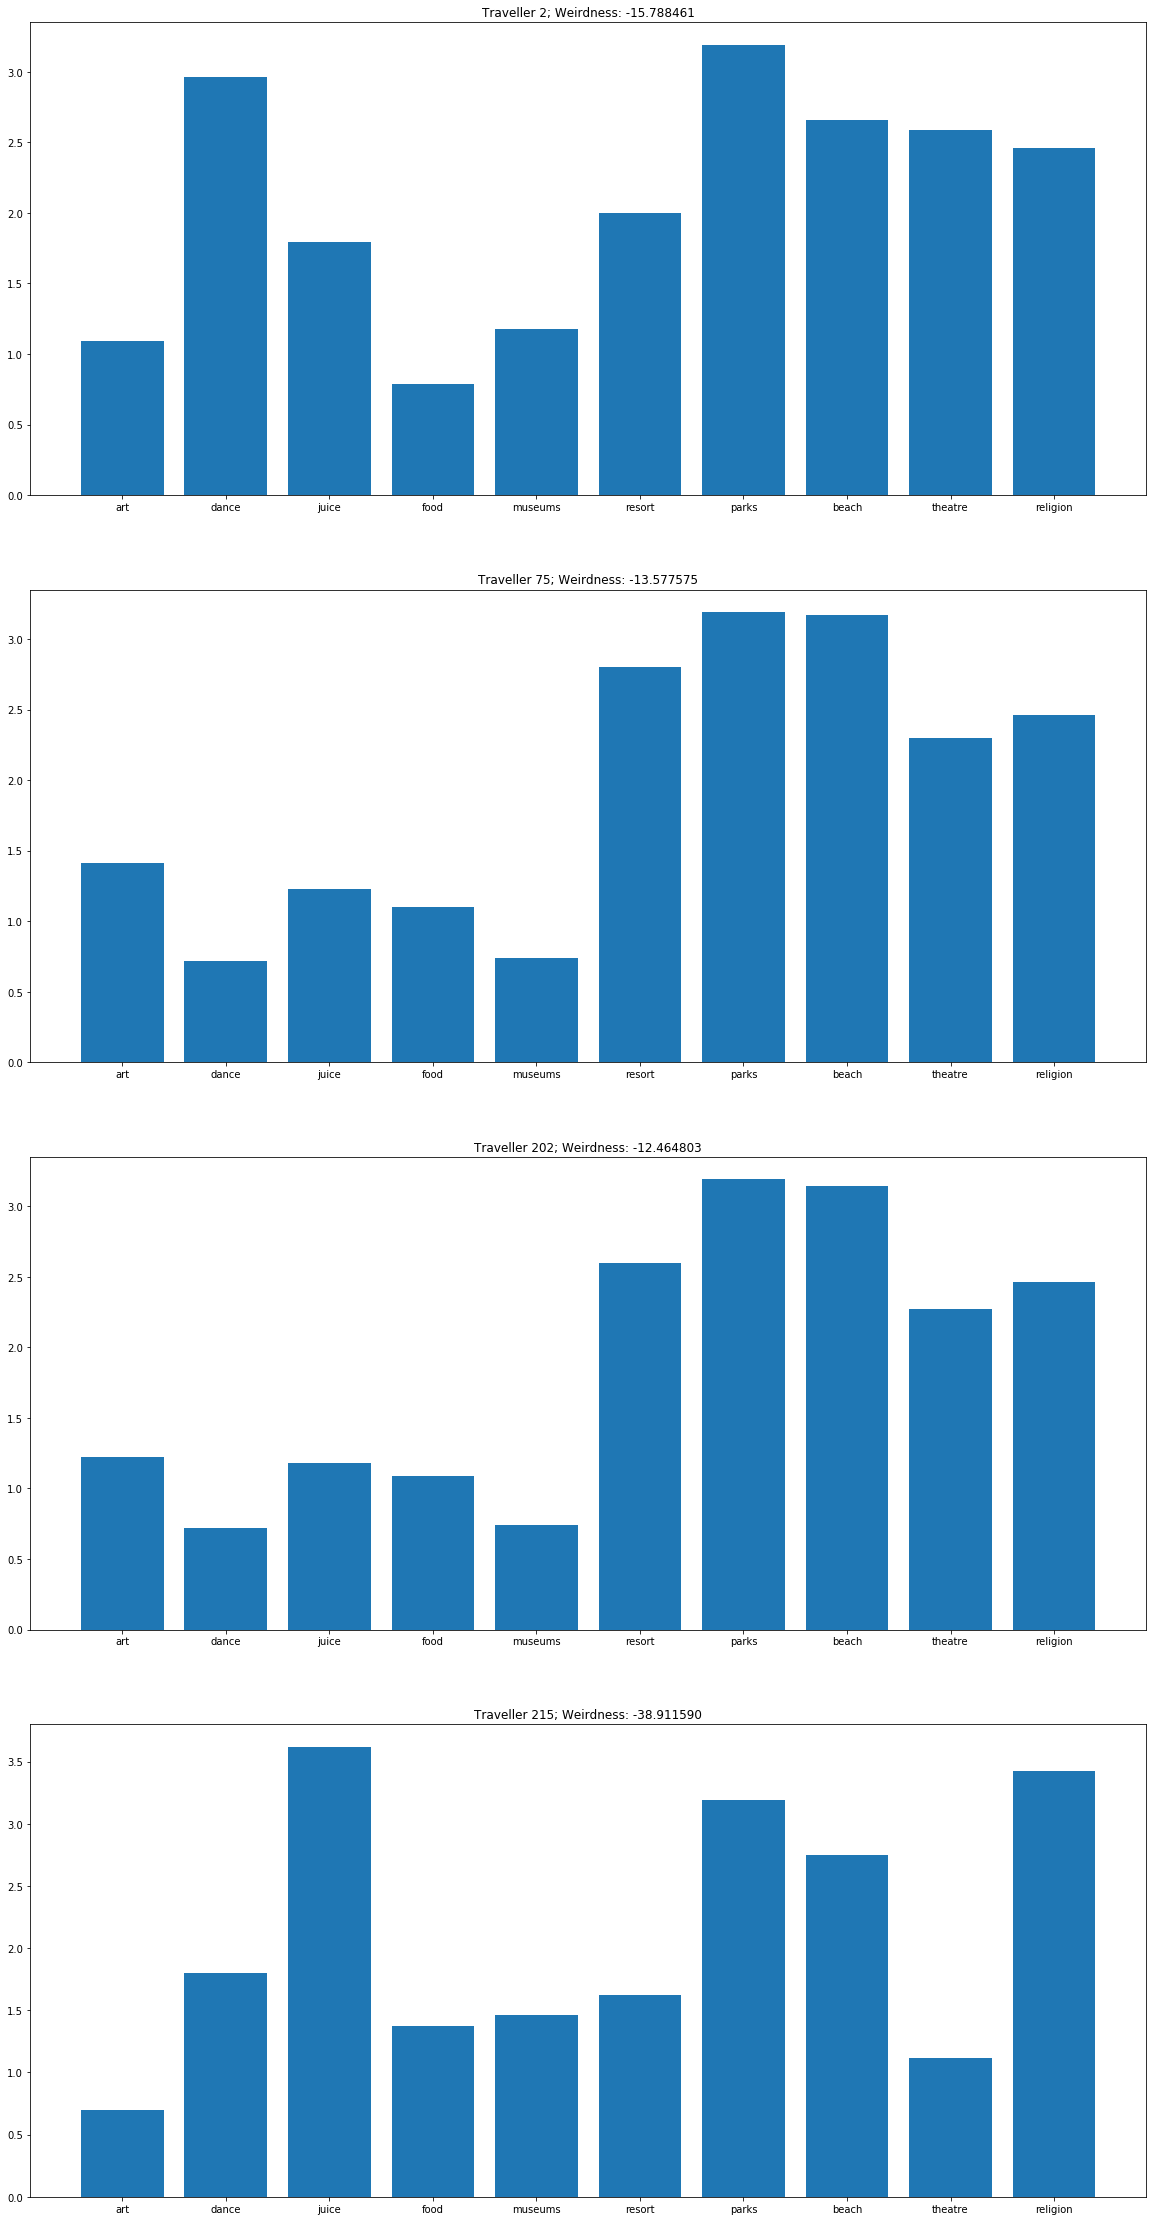

In [15]:
do_gmm_analysis(6, 314, train, test)

What we see is:
* Cluster distributions again look similar between runs. We're seeing cluster ID's "swap", but on the whole clustering is not varying wildly from one run to the next
* Our abnormalities are changing. Across the three runs we got the following abnormal travellers:
  * Run 1 (random seed = 4): 75, 95, 112, 188, 202, 214, 215, 253, 254
  * Run 2 (random seed = 42): 112, 167, 203, 215, 253
  * Run 3 (random seed = 314): 2, 75, 202, 215
* We see some numbers repeating here between sets, but not all. We also see quite different numbers of abnormal travellers being returned. The subtle changes in our distributions means that we get some quite different likelihoods for these edge cases. Ideally, we'd tune our threshold each time through.
* Our abnormal set only partially overlaps with the k-means set, and while some of our abnormalities appear to be at the cluster boundaries, others do not.

## Final Comments

There are a few things that we should keep in mind with the above:
* We don't actually know who, if anyone, is abnormal in this data, so it's hard to say which solution is more correct
* We are relying on the assumption that the first 700 subjects that we trained the data on are "normal". This is probably invalid. This doesn't mean we can't still do what we've done, we just need to be aware of this issue and keep it in mind when analysising the data
* The numbers of clusters we use will also impact results. Try repeating the above with different numbers of clusters for both methods and see what happens
* Thresholds are hard to set without data to use to help inform them. Here, we've used values that will pick up a few of the most abnormal points. You could modify the above code to always return the most N abnormal samples, which may help to compare successive runs of the functions